Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
from sklearn.datasets import load_digits
X = load_digits().data
y = load_digits().target
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy
numpy.version.version

'1.16.1'

In [3]:
first_10 = X[:10].reshape(10,8,8)

In [4]:
digits = load_digits()

In [5]:
digits.images.shape

(1797, 8, 8)

<Figure size 432x288 with 0 Axes>

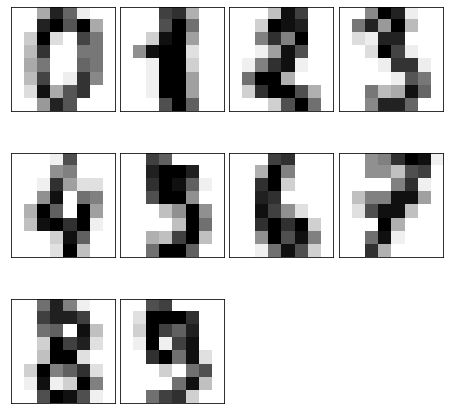

In [6]:
plt.gray()
fig = plt.figure(figsize=(6, 6)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(16-digits.images[i], interpolation='nearest')

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [8]:
model_1 = AgglomerativeClustering(n_clusters=10)
result_1 = model_1.fit_predict(X)
print(result_1.shape)
result_1

(1797,)


array([7, 9, 4, ..., 4, 1, 4], dtype=int64)

In [9]:
model_2 = KMeans(n_clusters=10, n_init=100)
result_2 = model_2.fit_predict(X)
print(result_2.shape)
result_2

(1797,)


array([6, 3, 3, ..., 3, 4, 4])

**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

<Figure size 432x288 with 0 Axes>

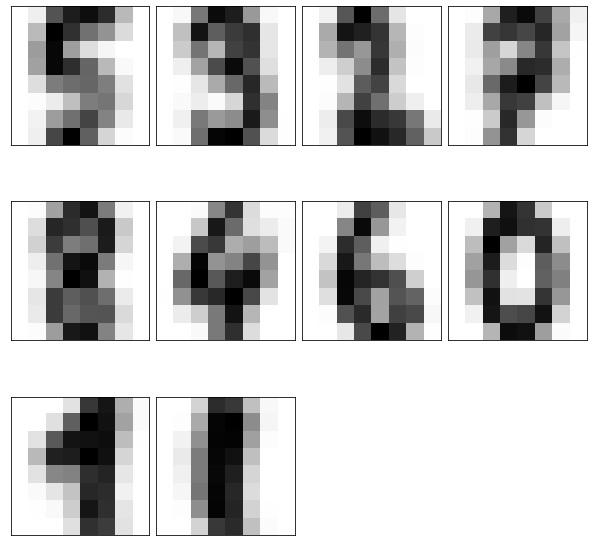

In [10]:
plt.gray()
fig = plt.figure(figsize=(8, 8)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    ax = fig.add_subplot(3, 4, i+1, xticks=[], yticks=[])
    ax.imshow(16-np.mean(X[result_1 == i], axis=0).reshape(8,8))

<Figure size 432x288 with 0 Axes>

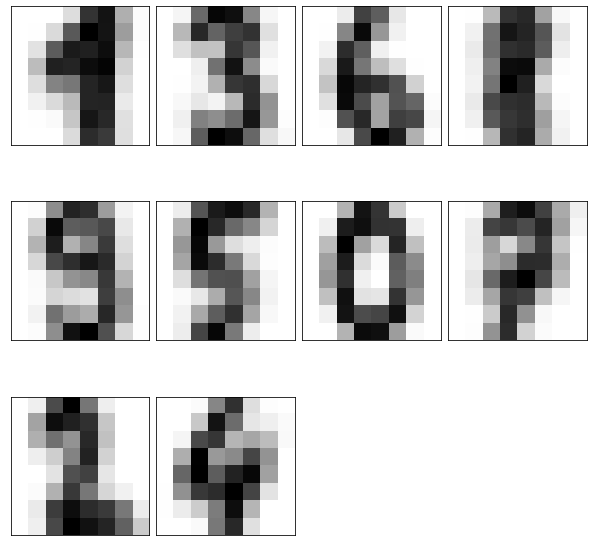

In [11]:
plt.gray()
fig = plt.figure(figsize=(8, 8)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    ax = fig.add_subplot(3, 4, i+1, xticks=[], yticks=[])
    ax.imshow(16-np.mean(X[result_2 == i], axis=0).reshape(8,8))

> I think that AgglomerativeClustering and KMeans performed more or less equal, maybe KMeans better a bit. Some digits are more clear after AgglomerativeClustering, others are better after KMeans.

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [4]:
from sklearn.metrics import silhouette_score

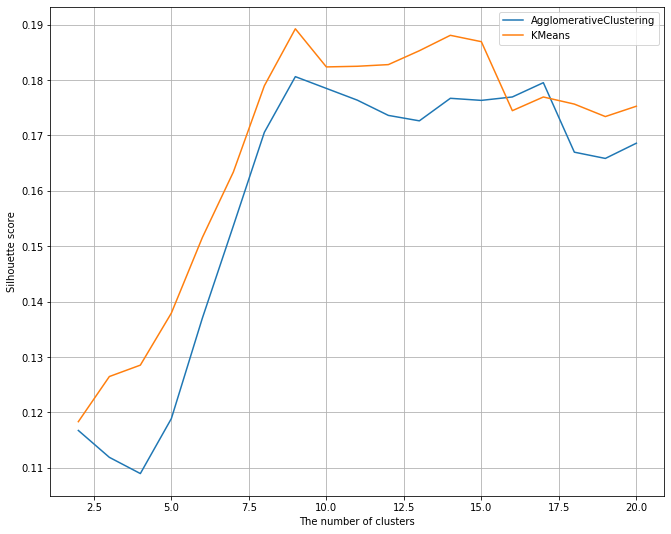

In [31]:
K = range(2,21)

list_k, list_sscore, list_kkscore = [], [], []
plt.figure(figsize = [11, 9])
for k in K:
    result_aggr = AgglomerativeClustering(n_clusters=k).fit_predict(X)
    result_km = KMeans(n_clusters=k, n_init=100).fit_predict(X)
    sscore = silhouette_score(X, result_aggr)
    kkscore = silhouette_score(X, result_km)
    list_k.append(k)
    list_sscore.append(sscore)
    list_kkscore.append(kkscore)
plt.plot(list_k, list_sscore, label = 'AgglomerativeClustering')
plt.plot(list_k, list_kkscore, label = 'KMeans')
plt.legend()
plt.grid(b=True)
plt.xlabel('The number of clusters')
plt.ylabel('Silhouette score')
plt.show();

In [69]:
print('AgglomerativeClustering max silhouette score is:', max(list_sscore))
print('KMeans max silhouette score is:', max(list_kkscore))
print('AgglomerativeClustering k=10 silhouette score is:', list_sscore[8])
print('KMeans k=10 silhouette score is:', list_kkscore[8])

AgglomerativeClustering max silhouette score is: 0.18061975703867697
KMeans max silhouette score is: 0.18925821286715278
AgglomerativeClustering k=10 silhouette score is: 0.17849659940596496
KMeans k=10 silhouette score is: 0.18237571549327078


>We can observe the following:
- AgglomerativeClustering has its max silhouette value given k=9 
- KMeans has its max silhouette value given k=9

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [4]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, homogeneity_completeness_v_measure

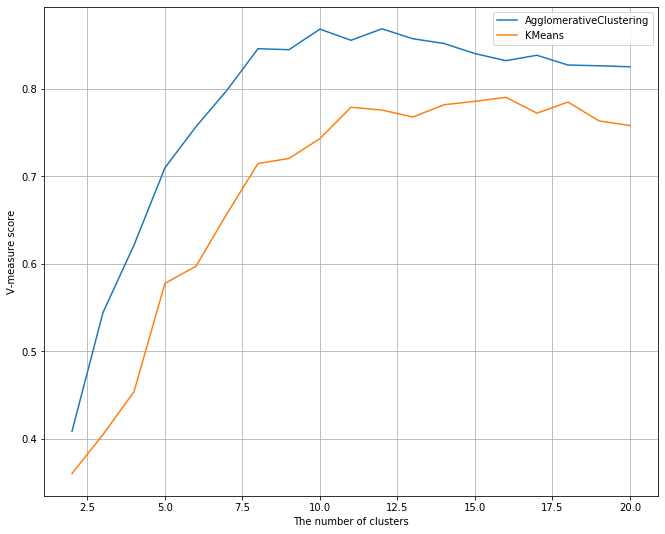

In [34]:
K = range(2,21)

list_k, list_vscore, list_kscore = [], [], []
plt.figure(figsize = [11, 9])
for k in K:
    result_aggr = AgglomerativeClustering(n_clusters=k).fit_predict(X)
    result_km = KMeans(n_clusters=k, n_init=100).fit_predict(X)
    vscore = v_measure_score(y, result_aggr)
    kscore = v_measure_score(y, result_km)
    list_k.append(k)
    list_vscore.append(vscore)
    list_kscore.append(kscore)
plt.plot(list_k, list_vscore, label = 'AgglomerativeClustering')
plt.plot(list_k, list_kscore, label = 'KMeans')
plt.legend()
plt.grid(b=True)
plt.xlabel('The number of clusters')
plt.ylabel('V-measure score')
plt.show();

In [70]:
print('AgglomerativeClustering max v_measure score is:', max(list_vscore))
print('KMeans max v_measure score is:', max(list_kscore))
print('AgglomerativeClustering k=10 v_measure score is:', list_vscore[8])
print('KMeans k=10 v_measure score is:', list_kscore[8])

AgglomerativeClustering max v_measure score is: 0.86854875186737
KMeans max v_measure score is: 0.790149227399694
AgglomerativeClustering k=10 v_measure score is: 0.8681701126909083
KMeans k=10 v_measure score is: 0.7430251165632649


>We can observe the following:
- AgglomerativeClustering has its max V-measure score given k=12 
- KMeans has its max V-measure score given k=16

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [5]:
from sklearn.decomposition import TruncatedSVD

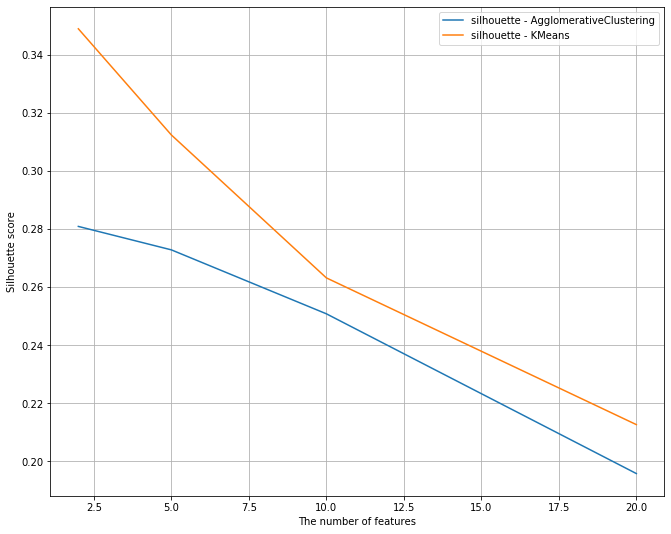

In [15]:
N = [2,5,10,20]

list_n, list_sa_score, list_sk_score = [], [], []
plt.figure(figsize = [11, 9])
for n in N:
    svd = TruncatedSVD(n_components=n, algorithm='arpack', random_state=42)
    X_svd = svd.fit_transform(X)
    result_aggr = AgglomerativeClustering(n_clusters=10).fit_predict(X_svd)
    result_km = KMeans(n_clusters=10, n_init=100).fit_predict(X_svd)
    sa_score = silhouette_score(X_svd, result_aggr)
    sk_score = silhouette_score(X_svd, result_km)
   
    list_n.append(n)
    list_sa_score.append(sa_score)
    list_sk_score.append(sk_score)

plt.plot(list_n, list_sa_score, label = 'silhouette - AgglomerativeClustering')
plt.plot(list_n, list_sk_score, label = 'silhouette - KMeans')

plt.legend()
plt.xlabel('The number of features')
plt.ylabel('Silhouette score')
plt.grid(b=True)
plt.show();

In [17]:
print('After TruncatedSVD AgglomerativeClustering max silhouette score is:', max(list_sa_score))
print('After TruncatedSVD KMeans max silhouette score is:', max(list_sk_score))
print('After TruncatedSVD AgglomerativeClustering k=10 silhouette score is:', list_sa_score[2])
print('After TruncatedSVD KMeans k=10 silhouette score is:', list_sk_score[2])

After TruncatedSVD AgglomerativeClustering max silhouette score is: 0.280816984920356
After TruncatedSVD KMeans max silhouette score is: 0.3489106049048945
After TruncatedSVD AgglomerativeClustering k=10 silhouette score is: 0.2507133748140163
After TruncatedSVD KMeans k=10 silhouette score is: 0.2630904624572578


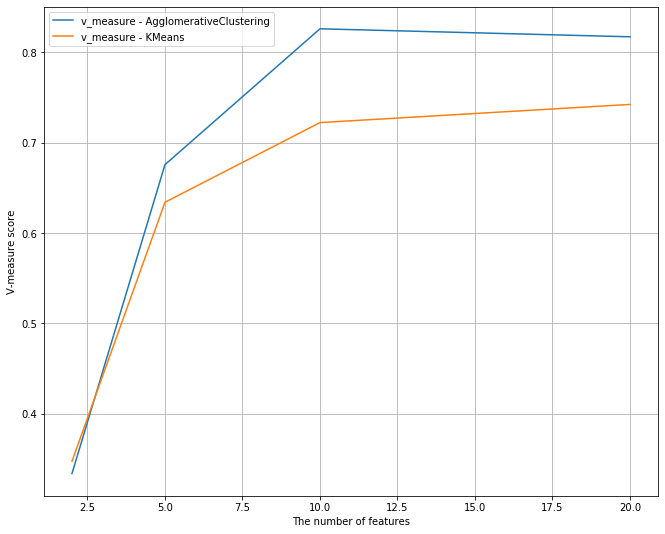

In [42]:
N = [2,5,10,20]

list_n, list_va_score, list_vk_score = [], [], []
plt.figure(figsize = [11, 9])
for n in N:
    svd = TruncatedSVD(n_components=n, algorithm='arpack', random_state=42)
    X_svd = svd.fit_transform(X)
    result_aggr = AgglomerativeClustering(n_clusters=10).fit_predict(X_svd)
    result_km = KMeans(n_clusters=10, n_init=100).fit_predict(X_svd)
    
    va_score = v_measure_score(y, result_aggr)
    vk_score = v_measure_score(y, result_km)
    list_n.append(n)

    list_va_score.append(va_score)
    list_vk_score.append(vk_score)

plt.plot(list_n, list_va_score, label = 'v_measure - AgglomerativeClustering')
plt.plot(list_n, list_vk_score, label = 'v_measure - KMeans')
plt.legend()
plt.grid(b=True)
plt.xlabel('The number of features')
plt.ylabel('V-measure score')
plt.show();

In [72]:
print('After TruncatedSVD AgglomerativeClustering max v_measure score is:', max(list_va_score))
print('After TruncatedSVD KMeans max v_measure score is:', max(list_vk_score))
print('After TruncatedSVD AgglomerativeClustering k=10 v_measure score is:', list_va_score[2])
print('After TruncatedSVD KMeans k=10 v_measure score is:', list_vk_score[2])

After TruncatedSVD AgglomerativeClustering max v_measure score is: 0.8259753348813222
After TruncatedSVD KMeans max v_measure score is: 0.7422729794392338
After TruncatedSVD AgglomerativeClustering k=10 v_measure score is: 0.8259753348813222
After TruncatedSVD KMeans k=10 v_measure score is: 0.7221574100459989


>So we can see that after TruncatedSVD we did not improve v_measure score after 𝑑′ features remained did not manage to overpass their initial values. But the silhouette score has increased.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [6]:
from sklearn.manifold import TSNE

In [19]:
tsn = TSNE(n_components=2, random_state=42)
X_tsn = tsn.fit_transform(X)

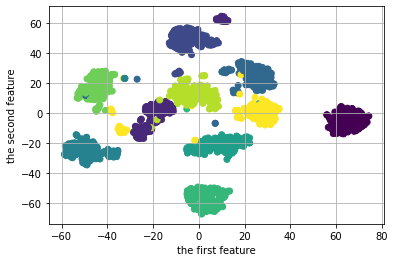

In [20]:
plt.scatter(X_tsn[:,0], X_tsn[:,1], c=y, cmap='viridis');
plt.grid(b=True)
plt.xlabel('the first feature')
plt.ylabel('the second feature');

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [21]:
res_aggr = AgglomerativeClustering(n_clusters=10).fit_predict(X_tsn)
res_km = KMeans(n_clusters=10, n_init=100).fit_predict(X_tsn)
print('After tSNE AgglomerativeClustering k=10 silhouette score is:', silhouette_score(X_tsn, res_aggr))
print('After tSNE KMeans k=10 silhouette score is:', silhouette_score(X_tsn, res_km))    
print('After tSNE AgglomerativeClustering k=10 v_measure score is:', v_measure_score(y, res_aggr))
print('After tSNE KMeans k=10 v_measure score is:', v_measure_score(y, res_km))

After tSNE AgglomerativeClustering k=10 silhouette score is: 0.6421834
After tSNE KMeans k=10 silhouette score is: 0.64323765
After tSNE AgglomerativeClustering k=10 v_measure score is: 0.9111471953871231
After tSNE KMeans k=10 v_measure score is: 0.9137798316714038


>We can see that we managed to improve the silhouette score by tSNE transformation (and its increasing is great, the result is much more higher than earlier). 
In addition, it can be said that we improved greatly v_measure score by tSNE transformation: it was 0.86817 and 0.74303 with AgglomerativeClustering and KMeans respectively, given k=10. This result is higher than all the previous scores.

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

<Figure size 432x288 with 0 Axes>

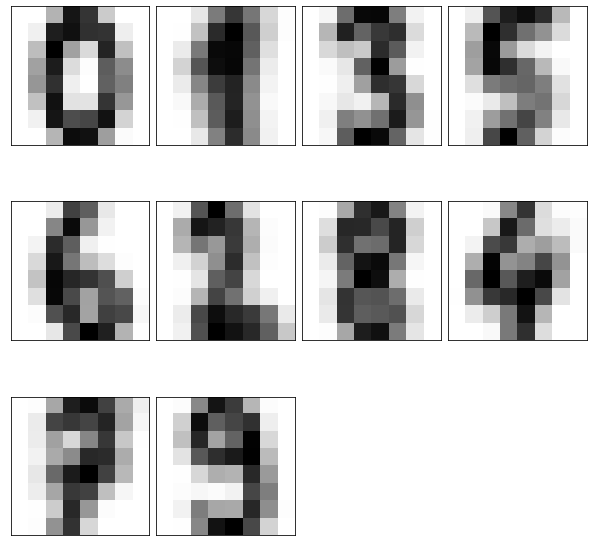

In [82]:
plt.gray()
fig = plt.figure(figsize=(8, 8)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(10):
    ax = fig.add_subplot(3, 4, i+1, xticks=[], yticks=[])
    ax.imshow(16-np.mean(X[res_km == i], axis=0).reshape(8,8))

>Yes, pictures above are more-less similar to digits. Only 2 and 7 may have some troubles with recognition, but other digits are relatively clear.

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

>In this example we worked with load_digits dataset. I think that AgglomerativeClustering and KMeans performed almost at the same level. For example, when we visualized clusters KMeans looked better. Then we measured silhouette and v_measure scores, KMeans tended to have better silhouette scores, AgglomerativeClustering showed higher v_measure scores. Moreover, performance depends on each algorithm hyperparameters tuning.
For the final evaluation I chose KMeans because after tSNE transformation given 10 clusters it had the highest v_measure, but it is important to note that the AgglomerativeClustering result was very close. 

>The quality of clusterization was improved after tSNE transformation in KMeans algorithm. But in general, I think that you should be careful with different feature space dimensionality reduction approaches and carefully select the best one, relying on clustering quality measures.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [7]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [10]:
tsn = TSNE(n_components=3, random_state=42)
mnist_tsn = tsn.fit_transform(mnist.data)

In [11]:
result_my = KMeans(n_clusters=10, n_init=70).fit_predict(mnist_tsn)

In [13]:
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, homogeneity_completeness_v_measure

In [14]:
v_measure_score(mnist.target, result_my)

0.7384271348275095

In [15]:
silhouette_score(mnist_tsn, result_my)

0.3226618

> I think it's not bad. When I tried PCA(.98), the v_measure_score was 0.4311, and the silhouette_score was 0.01169 - much worse than now. TruncatedSVD gave very similar low results.

>But obviously, these results can be improved. I had troubles with umap installing, so the second part of this task can be found via the link: 

https://colab.research.google.com/drive/1_U-G9NK9-2CXsmLOjflzfjBgnfEIwwFg?usp=sharing

>I applied UMAP reducer and got the v_measure_score equal to 0.8472, and the silhouette_score equal to 0.6176. Our metrics have improved, so in this case UMAP was the best solution for the dimentionality reduction. 